In [ ]:
# Reference: https://tianjinteda.github.io/Transunet.html

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loader

In [7]:
import os
import random
import h5py
import numpy as np
import torch

from PIL import Image
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset

<ipython-input-7-33d1217ae374>:9: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [8]:
def random_rot_flip(image, label):
    """
    이미지를 90배 k도 회전 (k: 0~3 사이의 무작위로 생성된 정수)
    임의의 축이 주어지면 이미지를 뒤집음
    """
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    """
    (-20, 20) 사이의 임의의 각도로 이미지를 회전
    (픽셀 보간을 위해 spline interpolation을 사용)
    """
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

In [9]:
class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)

        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3) # 삼차 스플라인 보간
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0) # 최근접 이웃 보간
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32))
        sample = {'image': image, 'label': label.long()}

        return sample

In [10]:
class SynapseDataset(Dataset):
    """
    인덱스가 주어진 각 데이터 샘플의 파일 이름을 찾아 데이터 디렉토리 경로를 파일 이름과 연결
    np.load 또는 h5py.File을 사용하여 데이터 로드
    데이터 샘플은 'image'와 'label'이 두 개의 key인 dictionary 데이터 구조로 캡슐화
    """
    def __init__(self, base_dir, list_dir, split, transform=None):
        self.transform = transform
        self.split = split
        self.sample_list = open(os.path.join(list_dir, self.split+'.txt')).readlines()
        self.data_dir = base_dir

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if self.split == "train":
            slice_name = self.sample_list[idx].strip('\n')
            data_path = os.path.join(self.data_dir, slice_name+'.npz')
            data = np.load(data_path)
            image, label = data['image'], data['label']
        else:
            vol_name = self.sample_list[idx].strip('\n')
            filepath = self.data_dir + "/{}.npy.h5".format(vol_name)
            data = h5py.File(filepath)
            image, label = data['image'][:], data['label'][:]

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        sample['case_name'] = self.sample_list[idx].strip('\n')

        return sample

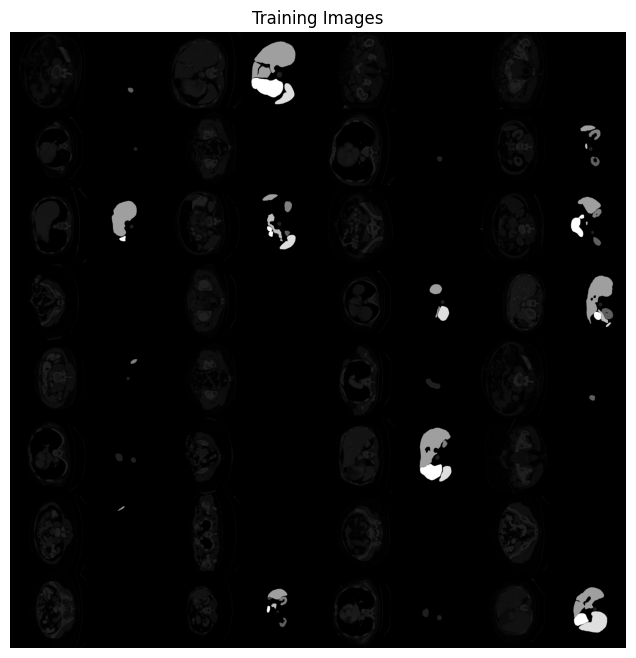

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch.utils.data import DataLoader


base_path = '/content/drive/MyDrive/Colab Notebooks/TransUNet'


# db_show = SynapseDataset(base_dir='./data/Synapse/train_npz',
#                          list_dir='./lists/lists_Synapse',
#                          split='train',
#                          transform=False)
db_show = SynapseDataset(base_dir=base_path + '/data/Synapse/train_npz',
                         list_dir=base_path + '/lists/lists_Synapse',
                         split='train',
                         transform=False)
showloader = DataLoader(db_show, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
real_batch = next(iter(showloader))
images = real_batch['image']
labels = real_batch['label']
data = []

for i in range(0, 32):
    data.append(images[i].unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
    data.append(labels[i].unsqueeze(0))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data, padding=2, normalize=True).cpu(), (1, 2, 0)))

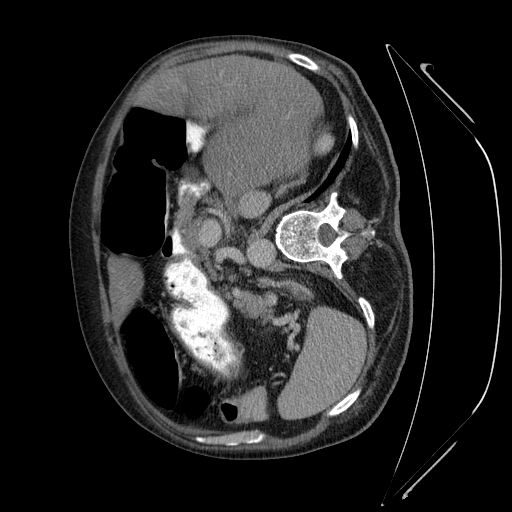

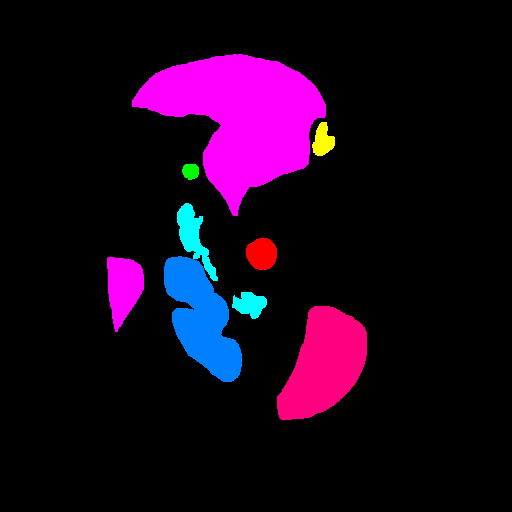

In [12]:
def make_coloured(image):
    coloured_image = np.zeros((512, 512, 3))

    for i in range(0, 512):
        for j in range(0, 512):
            if image[i][j] == 0:
                coloured_image[i][j][0] = 0
                coloured_image[i][j][1] = 0
                coloured_image[i][j][2] = 0
            elif image[i][j] == 1:
                coloured_image[i][j][0] = 1
                coloured_image[i][j][1] = 0
                coloured_image[i][j][2] = 0
            elif image[i][j] == 2:
                coloured_image[i][j][0] = 0
                coloured_image[i][j][1] = 1
                coloured_image[i][j][2] = 0
            elif image[i][j] == 3:
                coloured_image[i][j][0] = 0
                coloured_image[i][j][1] = 0
                coloured_image[i][j][2] = 1
            elif image[i][j] == 4:
                coloured_image[i][j][0] = 1
                coloured_image[i][j][1] = 1
                coloured_image[i][j][2] = 0
            elif image[i][j] == 5:
                coloured_image[i][j][0] = 1
                coloured_image[i][j][1] = 0
                coloured_image[i][j][2] = 1
            elif image[i][j] == 6:
                coloured_image[i][j][0] = 0
                coloured_image[i][j][1] = 1
                coloured_image[i][j][2] = 1
            elif image[i][j] == 7:
                coloured_image[i][j][0] = 1
                coloured_image[i][j][1] = 0
                coloured_image[i][j][2] = 0.5
            elif image[i][j] == 8:
                coloured_image[i][j][0] = 0
                coloured_image[i][j][1] = 0.5
                coloured_image[i][j][2] = 1

    return coloured_image


#data_path = './data/Synapse/train_npz/case0005_slice063.npz'
data_path = base_path + '/data/Synapse/train_npz/case0005_slice063.npz'
data = np.load(data_path)
image_original = data['image'][:]
label_image = data['label'][:]
coloured_label = make_coloured(label_image)

lbl = Image.fromarray((coloured_label * 255).astype(np.uint8))
iml = Image.fromarray((image_original * 255).astype(np.uint8))
# lb_path = 'label1.bmp'
# im_path = 'im1.bmp'
lb_path = base_path + '/label1.bmp'
im_path = base_path + '/im1.bmp'
lbl.save(lb_path)
iml.save(im_path)

display(Image.open(im_path))
display(Image.open(lb_path))

## ResNet

In [13]:
from os.path import join as pjoin
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F


def np2th(weights, conv=False):
    """
    Possibly convert HWIO to OIHW
    """
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


# standardize the weights before doing convolution
# weight --> (output_channel, input_channel, kernel_size[0], kernel_size[1])
# compute mean and variance for each input_channel * kernel_size[0] * kernel_size[1]
class StdConv2d(nn.Conv2d):
    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False) # weight standardization (각 output channel별로 평균과 분산 계산)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [14]:
class PreActBottleneck(nn.Module):
    """
    Pre-activation (v2) bottleneck block
    """
    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()

        cout = cout or cin
        cmid = cmid or cout // 4

        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride=stride, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            self.downsample = conv1x1(cin, cout, stride=stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))
        y = self.relu(y + residual)

        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

In [15]:
class ResNetV2(nn.Module):
    """
    Implementation of Pre-activation (v2) ResNet mode
    """
    def __init__(self, block_units, width_factor):
        super().__init__()

        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, padding=3, bias=False)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
            ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)

        for i in range(len(self.body) - 1):
            # concatenate the output of resnet blocks with decoder part so make sure that the height and width matches
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i + 1))

            if x.size(2) != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x

            features.append(feat) # append each features for U-Net structure

        x = self.body[-1](x)

        return x, features[::-1] # features[::-1] is for decoder part (저장된 features들을 뒤집어서 반환)

In [16]:
!pip install ml_collections

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.5 MB/s eta 0:00:00


In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math
import ml_collections
from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage


logger = logging.getLogger(__name__)


def get_b16_config():
    """
    Returns the ViT-B/16 configuration
    """
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    #config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.pretrained_path = base_path + '/model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'

    return config


def get_r50_b16_config():
    """
    Returns the ResNet50 + ViT-B/16 configuration
    """
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    #config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.pretrained_path = base_path + '/model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config


CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'R50-ViT-B_16': get_r50_b16_config(),
}

## Transformer

In [18]:
class Embeddings(nn.Module):
    """
    Construct the embeddings from patch, position embeddings
    """
    def __init__(self, config, img_size, in_channels=3):
        super().__init__()

        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)
        #print(config.patches.get("grid"))
        #print(img_size)

        if config.patches.get("grid") is not None: # ResNet
            """
            이미지 크기를 16x downsampling한 뒤, grid 크기만큼 패치로 분할
            최종적으로 패치 개수 (n_patches) 계산
            """
            grid_size = config.patches["grid"]
            #print(grid_size)
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            #print(patch_size, patch_size_real)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
            self.hybrid = True
        else:
            """
            config.patches["size"] 값을 이용하여 패치 크기 설정
            img_size를 patch_size로 나누어 총 패치 개수 (n_patches) 계산
            """
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16

        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))
        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None

        x = self.patch_embeddings(x) # (B, hidden, n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)      # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        return embeddings, features

In [19]:
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """
    Possibly convert HWIO to OIHW
    """
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super().__init__()

        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        # (batch, seq_len, hidden_size) -> (batch, seq_len, num_heads, head_size)
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.reshape(*new_x_shape)

        # (batch, seq_len, num_heads, head_size) -> (batch, num_heads, seq_len, head_size)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # (batch, seq_len, hidden_size) -> (batch, num_heads, seq_len, head_size)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.reshape(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)

        return attention_output, weights

In [20]:
class Mlp(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [21]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super().__init__()

        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h

        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"

        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT,ATTENTION_Q,"kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))

In [22]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super().__init__()

        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)

        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []

        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)

        encoded = self.encoder_norm(hidden_states)

        return encoded, attn_weights

In [23]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super().__init__()

        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output) # (b, n_patch, hidden)
        return encoded, attn_weights, features

## Decoder

In [24]:
class Conv2dReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, use_batchnorm=True):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=not(use_batchnorm))
        relu = nn.ReLU(inplace=True)
        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)

In [25]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels=0, use_batchnorm=True):
        super().__init__()

        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [26]:
class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config

        head_channels = 512

        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True
        )

        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4 - self.config.n_skip): # re-select the skip channels according to n_skip
                skip_channels[3-i] = 0
        else:
            skip_channels = [0, 0, 0, 0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size() # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().reshape(B, hidden, h, w)

        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)

        return x

In [27]:
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()

        super().__init__(conv2d, upsampling)

In [28]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super().__init__()

        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3
        )

        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x, attn_weights, features = self.transformer(x) # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)

        return logits

    def load_from(self, weights):
        with torch.no_grad():
            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

## Loss
$ DICE(x, y) = 1 - \frac{2 * |X * Y| + smooth value}{|X * X| + |Y * Y| + smooth value} $


In [29]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]

        return loss / self.n_classes

## Training

In [30]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.3 MB/s eta 0:00:00


In [31]:
import argparse
import logging
import os
import random
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms

In [32]:
def trainer_synapse(args, model, snapshot_path):
    logging.basicConfig(filename=snapshot_path + "/log.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))

    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    base_lr = args.base_lr
    num_classes = args.num_classes
    batch_size = args.batch_size * args.n_gpu
    #max_iterations = args.max_iterations
    db_train = SynapseDataset(base_dir=args.root_path,
                              list_dir=args.list_dir,
                              split='train',
                              transform=transforms.Compose([RandomGenerator(output_size=[args.img_size, args.img_size])]))
    print("The length of train set is: {}".format(len(db_train)))

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    trainloader = DataLoader(db_train,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=0,
                             pin_memory=True,
                             worker_init_fn=worker_init_fn)

    if args.n_gpu > 1:
        model = nn.DataParallel(model)

    model.train()

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(num_classes)
    optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0001)
    writer = SummaryWriter(snapshot_path + '/log')

    iter_num = 0
    max_epoch = args.max_epochs
    max_iterations = args.max_epochs + len(trainloader) # max_epoch = max_iterations // len(trainloader) + 1
    logging.info("{} iterations per epoch. {} max iterations".format(len(trainloader), max_iterations))
    best_performance = 0.0
    iterator = tqdm(range(max_epoch), ncols=70)

    for epoch_num in iterator:
        for i_batch, sampled_batch in enumerate(trainloader):
            image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)
            #image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
            outputs = model(image_batch)

            loss_ce = ce_loss(outputs, label_batch[:].long())
            loss_dice = dice_loss(outputs, label_batch, softmax=True)

            loss = 0.5 * loss_ce + 0.5 * loss_dice

            # if loss is complex, take only real part
            loss = loss.real if loss.is_complex() else loss
            loss_ce = loss_ce.real if loss_ce.is_complex() else loss_ce
            loss_dice = loss_dice.real if loss_dice.is_complex() else loss_dice

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

            iter_num = iter_num + 1
            writer.add_scalar('info/lr', lr_, iter_num)
            #writer.add_scalar('info/total_loss', loss, iter_num)
            #writer.add_scalar('info/loss_ce', loss_ce, iter_num)
            writer.add_scalar('info/total_loss', loss.real.item(), iter_num)
            writer.add_scalar('info/loss_ce', loss_ce.real.item(), iter_num)

            #logging.info('iteration %d : loss : %f, loss_ce : %f' % (iter_num, loss.item(), loss_ce.item()))
            logging.info('iteration %d : loss : %f, loss_ce : %f' % (iter_num, loss.real.item(), loss_ce.real.item()))

            if iter_num % 20 == 0:
                image = image_batch[1, 0:1, :, :]
                image = (image - image.min()) / (image.max() - image.min())
                writer.add_image('train/Image', image, iter_num)
                outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
                writer.add_image('train/Prediction', outputs[1, ...] * 50, iter_num)
                labs = label_batch[1, ...].unsqueeze(0) * 50
                writer.add_image('train/GroundTruth', labs, iter_num)

            save_interval = 50 # int(max_epoch / 6)
            if epoch_num > int(max_epoch / 2) and (epoch_num + 1) % save_interval == 0:
                save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
                torch.save(model.state_dict(), save_mode_path)
                logging.info("save model to {}".format(save_mode_path))

            if epoch_num >= max_epoch - 1:
                save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
                torch.save(model.state_dict(), save_mode_path)
                logging.info("save model to {}".format(save_mode_path))
                iterator.close()
                break

    writer.close()
    return "Training Finished!"

In [33]:
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn

In [34]:
parser = argparse.ArgumentParser()
# parser.add_argument('--root_path', type=str,
#                     default='./data/Synapse/train_npz', help='root dir for data')
parser.add_argument('--root_path', type=str,
                    default=base_path + '/data/Synapse/train_npz', help='root dir for data')
parser.add_argument('--dataset', type=str,
                    default='Synapse', help='experiment_name')
# parser.add_argument('--list_dir', type=str,
#                     default='./lists/lists_Synapse', help='list dir')
parser.add_argument('--list_dir', type=str,
                    default=base_path + '/lists/lists_Synapse', help='list dir')
parser.add_argument('--num_classes', type=int,
                    default=9, help='output channel of network')
parser.add_argument('--max_iterations', type=int,
                    default=30000, help='maximum epoch number to train')
parser.add_argument('--max_epochs', type=int,
                    default=150, help='maximum epoch number to train')
parser.add_argument('--batch_size', type=int,
                    default=24, help='batch_size per gpu')
parser.add_argument('--n_gpu', type=int, default=1, help='total gpu')
parser.add_argument('--deterministic', type=int,  default=1,
                    help='whether use deterministic training')
parser.add_argument('--base_lr', type=float,  default=0.01,
                    help='segmentation network learning rate')
parser.add_argument('--img_size', type=int,
                    default=224, help='input patch size of network input')
parser.add_argument('--seed', type=int,
                    default=1234, help='random seed')
parser.add_argument('--n_skip', type=int,
                    default=3, help='using number of skip-connect, default is num')
parser.add_argument('--vit_name', type=str,
                    default='R50-ViT-B_16', help='select one vit model')
parser.add_argument('--vit_patches_size', type=int,
                    default=16, help='vit_patches_size, default is 16')

args = parser.parse_args(args=['--root_path', base_path + '/data/Synapse/train_npz', # './data/Synapse/train_npz'
                               '--dataset','Synapse',
                               '--list_dir', base_path + '/lists/lists_Synapse',     # ./lists/lists_Synapse
                               '--num_classes','9',
                               '--max_iterations','30000',
                               '--max_epochs','150',
                               '--batch_size','24',
                               '--n_gpu','1',
                               '--deterministic','1',
                               '--base_lr','0.01',
                               '--img_size','224',
                               '--seed','1234',
                               '--n_skip','3',
                               '--vit_name','R50-ViT-B_16',
                               '--vit_patches_size','16'])

print(args)

Namespace(root_path='/content/drive/MyDrive/Colab Notebooks/TransUNet/data/Synapse/train_npz', dataset='Synapse', list_dir='/content/drive/MyDrive/Colab Notebooks/TransUNet/lists/lists_Synapse', num_classes=9, max_iterations=30000, max_epochs=150, batch_size=24, n_gpu=1, deterministic=1, base_lr=0.01, img_size=224, seed=1234, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16)


In [ ]:
if not args.deterministic:
    cudnn.benchmark = True
    cudnn.deterministic = False
else:
    cudnn.benchmark = False
    cudnn.deterministic = True

#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

dataset_name = args.dataset
dataset_config =  {
    'Synapse': {
        'root_path': base_path + '/data/Synapse/train_npz', # './data/Synapse/train_npz'
        'list_dir': base_path +'/lists/lists_Synapse',     # './lists/lists_Synapse'
        'num_classes': 9
    }
}

if args.batch_size != 24 and args.batch_size % 6 == 0:
    args.base_lr *= args.batch_size / 24
args.num_classes = dataset_config[dataset_name]['num_classes']
args.root_path = dataset_config[dataset_name]['root_path']
args.list_dir = dataset_config[dataset_name]['list_dir']
args.is_pretrain = True

args.exp = 'TU_' + dataset_name + str(args.img_size)
#snapshot_path = "model/{}/{}".format(args.exp, 'TU')
snapshot_path = base_path + "/model/{}/{}".format(args.exp, 'TU')
snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
snapshot_path += '_' + args.vit_name
snapshot_path = snapshot_path + '_skip' + str(args.n_skip)
snapshot_path = snapshot_path + '_vitpatch' + str(args.vit_patches_size) if args.vit_patches_size!=16 else snapshot_path
snapshot_path = snapshot_path+'_'+str(args.max_iterations)[0:2]+'k' if args.max_iterations != 30000 else snapshot_path
snapshot_path = snapshot_path + '_epo' +str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
snapshot_path = snapshot_path+'_bs'+str(args.batch_size)
snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
snapshot_path = snapshot_path + '_'+str(args.img_size)
snapshot_path = snapshot_path + '_s'+str(args.seed) if args.seed!=1234 else snapshot_path
if not os.path.exists(snapshot_path):
    os.makedirs(snapshot_path)

config_vit = CONFIGS[args.vit_name]

config_vit.n_classes = args.num_classes
config_vit.n_skip = args.n_skip
if args.vit_name.find('R50') != -1:
    config_vit.patches.grid = (int(args.img_size / args.vit_patches_size), int(args.img_size / args.vit_patches_size))
#print(config_vit.pretrained_path)
net = VisionTransformer(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes).to(device)
#net = VisionTransformer(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes).cuda()

trainer = {'Synapse': trainer_synapse,}
trainer[dataset_name](args, net, snapshot_path)

### Testing

In [ ]:
import argparse
import logging
import os
import random
import sys
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from medpy import metric
from scipy.ndimage import zoom
import SimpleITK as sitk

In [35]:
def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    elif pred.sum() > 0 and gt.sum()==0:
        return 1, 0
    else:
        return 0, 0


def test_single_volume(image, label, net, classes, patch_size=[256, 256], test_save_path=None, case=None, z_spacing=1):
    image, label = image.squeeze(0).cpu().detach().numpy(), label.squeeze(0).cpu().detach().numpy()
    if len(image.shape) == 3:
        prediction = np.zeros_like(label)
        for ind in range(image.shape[0]):
            slice = image[ind, :, :]
            x, y = slice.shape[0], slice.shape[1]
            if x != patch_size[0] or y != patch_size[1]:
                slice = zoom(slice, (patch_size[0] / x, patch_size[1] / y), order=3)  # previous using 0
            input = torch.from_numpy(slice).unsqueeze(0).unsqueeze(0).float().cuda()
            net.eval()
            with torch.no_grad():
                outputs = net(input)
                out = torch.argmax(torch.softmax(outputs, dim=1), dim=1).squeeze(0)
                out = out.cpu().detach().numpy()
                if x != patch_size[0] or y != patch_size[1]:
                    pred = zoom(out, (x / patch_size[0], y / patch_size[1]), order=0)
                else:
                    pred = out
                prediction[ind] = pred
                if np.max(pred) != 0:
                    np.save('predictions/result_image_synapse/' + case + "_pred_", pred)
                    np.save('predictions/result_image_synapse/' + case + "_gt_", label)
    else:
        input = torch.from_numpy(image).unsqueeze(
            0).unsqueeze(0).float().cuda()
        net.eval()
        with torch.no_grad():
            out = torch.argmax(torch.softmax(net(input), dim=1), dim=1).squeeze(0)
            prediction = out.cpu().detach().numpy()

    metric_list = []
    for i in range(1, classes):
        metric_list.append(calculate_metric_percase(prediction == i, label == i))

    if test_save_path is not None:
        img_itk = sitk.GetImageFromArray(image.astype(np.float32))
        prd_itk = sitk.GetImageFromArray(prediction.astype(np.float32))
        lab_itk = sitk.GetImageFromArray(label.astype(np.float32))
        img_itk.SetSpacing((1, 1, z_spacing))
        prd_itk.SetSpacing((1, 1, z_spacing))
        lab_itk.SetSpacing((1, 1, z_spacing))
        sitk.WriteImage(prd_itk, test_save_path + '/'+case + "_pred.nii.gz")
        sitk.WriteImage(img_itk, test_save_path + '/'+ case + "_img.nii.gz")
        sitk.WriteImage(lab_itk, test_save_path + '/'+ case + "_gt.nii.gz")

    return metric_list

In [ ]:
parser = argparse.ArgumentParser()

# parser.add_argument('--volume_path', type=str,
#                     default='./data/Synapse/test_vol_h5', help='root dir for validation volume data')  # for acdc volume_path=root_dir
parser.add_argument('--volume_path', type=str,
                    default=base_path + '/data/Synapse/test_vol_h5', help='root dir for validation volume data')
parser.add_argument('--dataset', type=str,
                    default='Synapse', help='experiment_name')
parser.add_argument('--num_classes', type=int,
                    default=4, help='output channel of network')
# parser.add_argument('--list_dir', type=str,
#                     default='./lists/lists_Synapse', help='list dir')
parser.add_argument('--list_dir', type=str,
                    default=base_path + '/lists/lists_Synapse', help='list dir')

parser.add_argument('--max_iterations', type=int,default=20000, help='maximum epoch number to train')
parser.add_argument('--max_epochs', type=int, default=150, help='maximum epoch number to train')
parser.add_argument('--batch_size', type=int, default=24,
                    help='batch_size per gpu')
parser.add_argument('--img_size', type=int, default=224, help='input patch size of network input')
parser.add_argument('--is_savenii', action="store_true", help='whether to save results during inference', default=True)

parser.add_argument('--n_skip', type=int, default=3, help='using number of skip-connect, default is num')
parser.add_argument('--vit_name', type=str, default='R50-ViT-B_16', help='select one vit model')

parser.add_argument('--test_save_dir', type=str, default='predictions', help='saving prediction as nii!')
parser.add_argument('--deterministic', type=int,  default=1, help='whether use deterministic training')
parser.add_argument('--base_lr', type=float,  default=0.01, help='segmentation network learning rate')
parser.add_argument('--seed', type=int, default=1234, help='random seed')
parser.add_argument('--vit_patches_size', type=int, default=16, help='vit_patches_size, default is 16')

args = parser.parse_args(args=['--volume_path', base_path + '/data/Synapse/test_vol_h5', # './data/Synapse/test_vol_h5'
                               '--dataset','Synapse',
                               '--num_classes','9',
                               '--list_dir', base_path + '/lists/lists_Synapse',         # './lists/lists_Synapse'
                               '--max_iterations','20000',
                               '--max_epochs','150',
                               '--batch_size','24',
                               '--img_size','224',
                               '--n_skip', '3',
                               '--vit_name','R50-ViT-B_16',
                               '--test_save_dir', 'predictions',
                               '--deterministic', '1',
                               '--base_lr', '0.01',
                               '--seed','1234',
                               '--vit_patches_size','16',
                               ])

print(args)

In [ ]:
def inference(args, model, test_save_path=None):
    db_test = args.Dataset(base_dir=args.volume_path, split="test_vol", list_dir=args.list_dir)
    testloader = DataLoader(db_test, batch_size=1, shuffle=False, num_workers=0)
    logging.info("{} test iterations per epoch".format(len(testloader)))

    model.eval()
    metric_list = 0.0
    for i_batch, sampled_batch in tqdm(enumerate(testloader)):
        h, w = sampled_batch["image"].size()[2:]
        image, label, case_name = sampled_batch["image"], sampled_batch["label"], sampled_batch["case_name"][0]
        metric_i = test_single_volume(image, label, model,
                                      classes=args.num_classes,
                                      patch_size=[args.img_size, args.img_size],
                                      test_save_path=test_save_path,
                                      case=case_name,
                                      z_spacing=args.z_spacing)
        metric_list += np.array(metric_i)
        logging.info('idx %d case %s mean_dice %f mean_hd95 %f' % (i_batch, case_name, np.mean(metric_i, axis=0)[0], np.mean(metric_i, axis=0)[1]))

    metric_list = metric_list / len(db_test)

    for i in range(1, args.num_classes):
        logging.info('Mean class %d mean_dice %f mean_hd95 %f' % (i, metric_list[i-1][0], metric_list[i-1][1]))

    performance = np.mean(metric_list, axis=0)[0]
    mean_hd95 = np.mean(metric_list, axis=0)[1]
    logging.info('Testing performance in best val model: mean_dice : %f mean_hd95 : %f' % (performance, mean_hd95))

    return "Testing Finished!"


if not args.deterministic:
    cudnn.benchmark = True
    cudnn.deterministic = False
else:
    cudnn.benchmark = False
    cudnn.deterministic = True

#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

dataset_config = {
    'Synapse': {
        'Dataset': SynapseDataset,
        'volume_path': base_path + '/data/Synapse/test_vol_h5', # './data/Synapse/test_vol_h5'
        'list_dir': base_path + '/lists/lists_Synapse',         # './lists/lists_Synapse'
        'num_classes': 9,
        'z_spacing': 1,
    },
}

dataset_name = args.dataset
args.num_classes = dataset_config[dataset_name]['num_classes']
args.volume_path = dataset_config[dataset_name]['volume_path']
args.Dataset = dataset_config[dataset_name]['Dataset']
args.list_dir = dataset_config[dataset_name]['list_dir']
args.z_spacing = dataset_config[dataset_name]['z_spacing']
args.is_pretrain = True

# name the same snapshot defined in train script!
args.exp = 'TU_' + dataset_name + str(args.img_size)
snapshot_path = "model/{}/{}".format(args.exp, 'TU')
snapshot_path = snapshot_path + '_pretrain' if args.is_pretrain else snapshot_path
snapshot_path += '_' + args.vit_name
snapshot_path = snapshot_path + '_skip' + str(args.n_skip)
snapshot_path = snapshot_path + '_vitpatch' + str(args.vit_patches_size) if args.vit_patches_size!=16 else snapshot_path
snapshot_path = snapshot_path + '_epo' + str(args.max_epochs) if args.max_epochs != 30 else snapshot_path
if dataset_name == 'ACDC':  # using max_epoch instead of iteration to control training duration
    snapshot_path = snapshot_path + '_' + str(args.max_iterations)[0:2] + 'k' if args.max_iterations != 30000 else snapshot_path
snapshot_path = snapshot_path+'_bs'+str(args.batch_size)
snapshot_path = snapshot_path + '_lr' + str(args.base_lr) if args.base_lr != 0.01 else snapshot_path
snapshot_path = snapshot_path + '_'+str(args.img_size)
snapshot_path = snapshot_path + '_s'+str(args.seed) if args.seed!=1234 else snapshot_path

config_vit = CONFIGS[args.vit_name]
config_vit.n_classes = args.num_classes
config_vit.n_skip = args.n_skip
config_vit.patches.size = (args.vit_patches_size, args.vit_patches_size)
if args.vit_name.find('R50') !=-1:
    config_vit.patches.grid = (int(args.img_size/args.vit_patches_size), int(args.img_size/args.vit_patches_size))
net = VisionTransformer(config_vit, img_size=args.img_size, num_classes=config_vit.n_classes).to(device)

snapshot = os.path.join(snapshot_path, 'best_model.pth')
if not os.path.exists(snapshot): snapshot = snapshot.replace('best_model', 'epoch_'+str(args.max_epochs-1))
net.load_state_dict(torch.load(snapshot.replace('\\', '/')))
snapshot_name = snapshot_path.split('/')[-1]

#log_folder = './test_log/test_log_' + args.exp
log_folder = base_path + '/test_log/test_log_' + args.exp
os.makedirs(log_folder, exist_ok=True)
logging.basicConfig(filename=log_folder + '/'+snapshot_name+".txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
logging.info(str(args))
logging.info(snapshot_name)

if args.is_savenii:
    #args.test_save_dir = 'predictions'
    args.test_save_dir = base_path + '/predictions'
    test_save_path = os.path.join(args.test_save_dir, args.exp, snapshot_name)
    os.makedirs(test_save_path, exist_ok=True)
else:
    test_save_path = None

inference(args, net, test_save_path)

In [ ]:
#gt = np.load('predictions/result/result_image/case0029_gt_60.npy')
gt = np.load(base_path + '/predictions/result/result_image/case0029_gt_60.npy')
gt = make_coloured(gt)
gt = Image.fromarray(np.uint8(gt*255))
#gt_path = 'gt1.bmp'
gt_path = base_path + '/gt1.bmp'
gt.save(gt_path)
display(Image.open(gt_path))

#pred = np.load('predictions/result_image/case0029_pred_60.npy')
pred = np.load(base_path + '/predictions/result_image/case0029_pred_60.npy')
pred = make_coloured(pred)
pred = Image.fromarray(np.uint8(pred*255))
#pred_path='pred1.bmp'
pred_path = base_path + '/pred1.bmp'
pred.save(pred_path)
display(Image.open(pred_path))

In [ ]:
import matplotlib.pyplot as plt


def get_loss(file_path):
    with open(file_path, 'r') as f:
        content = f.readlines()
        total = 0
        loss = [0] * 150

        for i in range(0, 13950):
            total += float(content[i].split(' ')[6][:-1])
            if (i+1) % 93 == 0:
                loss[i // 93] = total / 93
                total = 0

    return loss


x = list(range(1, 151))
sgd_loss = get_loss('sgd_log.txt')
rmsprop_loss = get_loss('rmsprop_log.txt')
adadelta_loss = get_loss('adadelta_log.txt')
adam_loss = get_loss('adam_log.txt')

plt.plot(x, sgd_loss)
plt.plot(x, sgd_loss)
plt.plot(x, adadelta_loss)
plt.plot(x, adam_loss)
plt.legend(['SGD loss', 'RMSprop loss', 'Adadelta loss', 'Adam loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')